In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, roc_curve, precision_recall_curve, confusion_matrix, classification_report
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.layers import Layer
from tensorflow_probability import distributions as tfd
import matplotlib.pyplot as plt

/var/folders/72/24j7jy9s6sb2xm_dc84kdhm00000gn/T/ipykernel_90073/2848244596.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-07-06 13:28:56.332207: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/edoardozappia/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 's

In [2]:
df = pd.read_csv('/Users/edoardozappia/Downloads/creditcard.csv')

In [3]:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]

In [4]:
data = df.drop(['Time'], axis=1)
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

In [5]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=42)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)

print(X_train.shape)

#y_test = X_test['Class']
#X_test = X_test.drop(['Class'], axis=1)

X_train = X_train.values
#X_test = X_test.values

(227451, 29)


In [6]:
class_0 = X_test[X_test.Class == 0]
class_1 = X_test[X_test.Class == 1]

total_size = len(X_test)
desired_size_class_1 = int(total_size * 0.4)
desired_size_class_0 = total_size - desired_size_class_1

class_1_sampled = class_1.sample(n=desired_size_class_1, replace=True, random_state=42)
class_0_sampled = class_0.sample(n=desired_size_class_0, replace=True, random_state=42)

balanced_data = pd.concat([class_0_sampled, class_1_sampled])

X_test = balanced_data.drop('Class', axis=1)
y_test = balanced_data['Class']

X_test = X_test.values
y_test = y_test.values
print(y_test)

[0 0 0 ... 1 1 1]


In [7]:
print(np.count_nonzero(y_test == 0))
print(np.count_nonzero(y_test == 1))

34178
22784


In [8]:
input_dim = X_train.shape[1]
input_shape=(29,)
print(input_dim)
original_dim = input_dim  # Esempio di dimensione dell'input originale
intermediary_dims = [20, 10 ,8]
latent_dim = 2  # Esempio di dimensione dello spazio latente

29


In [9]:
tfk = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers

# Definizione della classe MultivariateNormalTriLLayer
class MultivariateNormalTriLLayer(tfkl.Layer):
    def __init__(self, latent_dim, **kwargs):
        super(MultivariateNormalTriLLayer, self).__init__(**kwargs)
        self.latent_dim = latent_dim

    def build(self, input_shape):
        self.untransformed_scale_tril = self.add_weight(name='untransformed_scale_tril',
                                                        shape=(self.latent_dim * (self.latent_dim + 1) // 2,),
                                                        initializer='random_normal',
                                                        trainable=True)
        super(MultivariateNormalTriLLayer, self).build(input_shape)

    def call(self, inputs):
        loc = inputs[..., :self.latent_dim]
        scale_tril = tfp.math.fill_triangular(self.untransformed_scale_tril)
        dist = tfd.MultivariateNormalTriL(loc=loc, scale_tril=scale_tril)
        sample = dist.sample()
        return sample  # Return the sample, not the distribution object

# Definizione della funzione dense_layers
def dense_layers(intermediary_dims):
    return tfk.Sequential([
        tfkl.Dense(units, activation='relu') for units in intermediary_dims
    ])

# Definizione del decoder come una classe Layer
class Decoder(tfkl.Layer):
    def __init__(self, original_dim, intermediary_dims, name='decoder', **kwargs):
        super(Decoder, self).__init__(name=name, **kwargs)
        self.original_dim = original_dim
        self.decoder_hidden = tf.keras.Sequential([
            tf.keras.layers.Dense(units, activation='relu') for units in reversed(intermediary_dims) #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        ] + [
            tf.keras.layers.Dense(original_dim, activation='sigmoid')
        ])

    def call(self, inputs):
        return self.decoder_hidden(inputs)

# Definizione del modello VAE
class VAE(tf.keras.Model):
    def __init__(self, original_dim, intermediary_dims, latent_dim, prior, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.original_dim = original_dim
        self.intermediary_dims = intermediary_dims
        self.latent_dim = latent_dim
        self.prior = prior

        # Encoder
        self.encoder_inputs = tf.keras.Input(shape=(original_dim,), name='encoder_input')
        self.encoder = self.build_encoder()

        # Decoder
        self.decoder = Decoder(original_dim, intermediary_dims)

    def build_encoder(self):
        x = dense_layers(self.intermediary_dims)(self.encoder_inputs)
        params = tfkl.Dense(tfpl.MultivariateNormalTriL.params_size(self.latent_dim), activation=None)(x)
        z = MultivariateNormalTriLLayer(self.latent_dim)(params)
        return tf.keras.Model(self.encoder_inputs, [z, params], name='encoder')

    @tf.function
    def call(self, inputs):
        if isinstance(inputs, tuple):
            inputs = inputs[0]
        z_sample, _ = self.encoder(inputs)  # Otteniamo sia z_sample che params
        reconstructed = self.decoder(z_sample)
        return reconstructed

    def compute_kl_divergence(self, q_z_x_params):
        q_distribution = tfd.MultivariateNormalTriL(loc=q_z_x_params[..., :self.latent_dim],
                                                    scale_tril=tfp.math.fill_triangular(q_z_x_params[..., self.latent_dim:]))
        p_distribution = self.prior
        return tfd.kl_divergence(q_distribution, p_distribution)

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
            
        with tf.GradientTape() as tape:
            reconstructed = self(data)
            reconstruction_loss_fn = tf.keras.losses.MeanSquaredError()
            reconstruction_loss = reconstruction_loss_fn(data, reconstructed)
            reconstruction_loss *= self.original_dim
            print(reconstruction_loss)
            z_sample, q_z_x_params = self.encoder(data)
            kl_divergence = tf.reduce_mean(self.compute_kl_divergence(q_z_x_params))

            elbo_loss = reconstruction_loss + kl_divergence
        gradients = tape.gradient(elbo_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        return {"loss": elbo_loss, "reconstruction_loss": reconstruction_loss, "kl_divergence": kl_divergence}

# Definizione dei parametri
input_dim = X_train.shape[1]
original_dim = input_dim
intermediary_dims = [20, 10, 8]
latent_dim = 2
prior = tfd.MultivariateNormalDiag(loc=tf.zeros(latent_dim), scale_diag=tf.ones(latent_dim))

# Creazione dell'istanza del modello VAE
vae = VAE(original_dim, intermediary_dims, latent_dim, prior)

# Compilazione del modello specificando la loss
vae.compile(optimizer=tf.keras.optimizers.Adam())

# Allenamento del modello
history = vae.fit(X_train, X_train, epochs=50, batch_size=64)


Epoch 1/50
Tensor("mul:0", shape=(), dtype=float32)


/Users/edoardozappia/Library/Python/3.9/lib/python/site-packages/keras/src/optimizers/base_optimizer.py:664: UserWarning: Gradients do not exist for variables ['kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


Tensor("mul:0", shape=(), dtype=float32)
3554/3554 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - kl_divergence: 0.1330 - loss: 37.6667 - reconstruction_loss: 37.5337
Epoch 2/50
3554/3554 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - kl_divergence: 0.0601 - loss: 37.5126 - reconstruction_loss: 37.4525
Epoch 3/50
3554/3554 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - kl_divergence: 0.0598 - loss: 37.5157 - reconstruction_loss: 37.4559
Epoch 4/50
3554/3554 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - kl_divergence: 0.0597 - loss: 37.5150 - reconstruction_loss: 37.4553
Epoch 5/50
3554/3554 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - kl_divergence: 0.0598 - loss: 37.5100 - reconstruction_loss: 37.4502
Epoch 6/50
3554/3554 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - kl_divergence: 0.0587 - loss: 37.5048 - reconstruction_loss: 37.4461
Epoch 7/50
3554/3554 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - kl_divergence: 0.0602 - loss: 37.5067 - reconstruction_loss: 37.4465
Epoch 8/50
3554/3554 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - kl_divergence: 0.0593 - loss: 37.5150

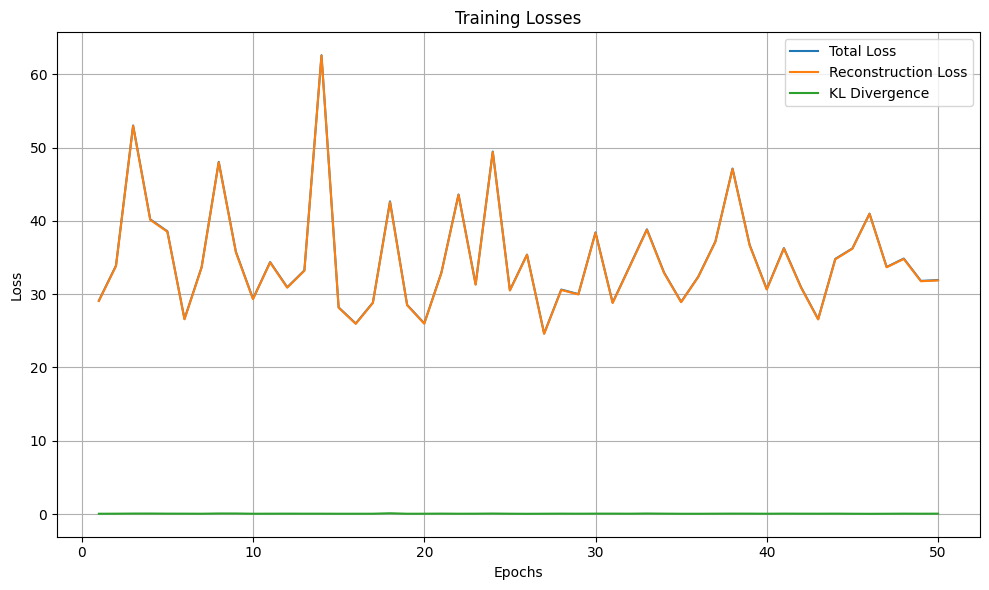

In [10]:
# Estrazione della loss
loss = history.history['loss']
reconstruction_loss = history.history['reconstruction_loss']
kl_divergence = history.history['kl_divergence']

# Plot della loss
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Total Loss')
plt.plot(epochs, reconstruction_loss, label='Reconstruction Loss')
plt.plot(epochs, kl_divergence, label='KL Divergence')

plt.title('Training Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

In [11]:
# Calcolo della perdita di ricostruzione su X_test
reconstructed = vae.decoder(vae.encoder(X_test)).numpy()
reconstruction_loss = np.mean(np.square(X_test - reconstructed), axis=1)

print(reconstruction_loss)

# Definizione di una soglia arbitraria (può essere ottimizzata)
threshold = 2.5

# Creazione di un array binario per le previsioni basate sulla soglia
predictions = (reconstruction_loss > threshold).astype(np.int32)


[  0.60259456   0.66229315   1.39831373 ...   1.29770447   3.62219239
 109.69709251]


Threshold: 0.2834	Accuracy: 0.400		Precision: 0.700	Recall Score: 0.500
Threshold: 0.3905	Accuracy: 0.410		Precision: 0.702	Recall Score: 0.508
Threshold: 0.4175	Accuracy: 0.417		Precision: 0.662	Recall Score: 0.513
Threshold: 0.4347	Accuracy: 0.422		Precision: 0.634	Recall Score: 0.516
Threshold: 0.4546	Accuracy: 0.432		Precision: 0.654	Recall Score: 0.525
Threshold: 0.4732	Accuracy: 0.442		Precision: 0.667	Recall Score: 0.533
Threshold: 0.4913	Accuracy: 0.452		Precision: 0.676	Recall Score: 0.541
Threshold: 0.5084	Accuracy: 0.462		Precision: 0.683	Recall Score: 0.550
Threshold: 0.5237	Accuracy: 0.472		Precision: 0.689	Recall Score: 0.558
Threshold: 0.5414	Accuracy: 0.482		Precision: 0.694	Recall Score: 0.566
Threshold: 0.5591	Accuracy: 0.492		Precision: 0.699	Recall Score: 0.575
Threshold: 0.5763	Accuracy: 0.502		Precision: 0.703	Recall Score: 0.583
Threshold: 0.5907	Accuracy: 0.512		Precision: 0.707	Recall Score: 0.591
Threshold: 0.6051	Accuracy: 0.522		Precision: 0.711	Recall Score

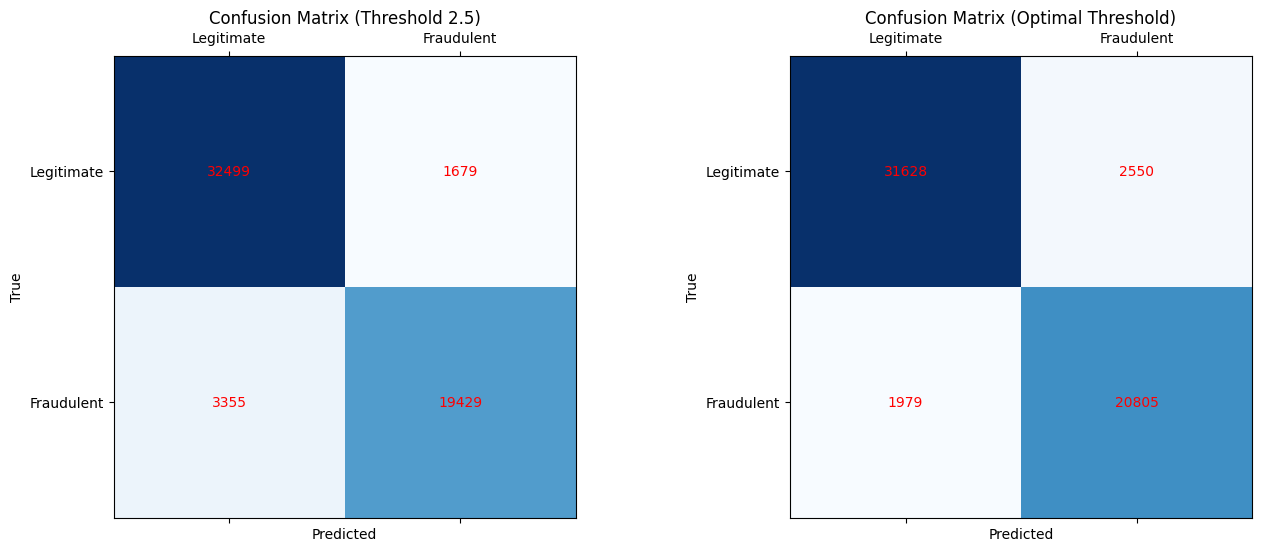

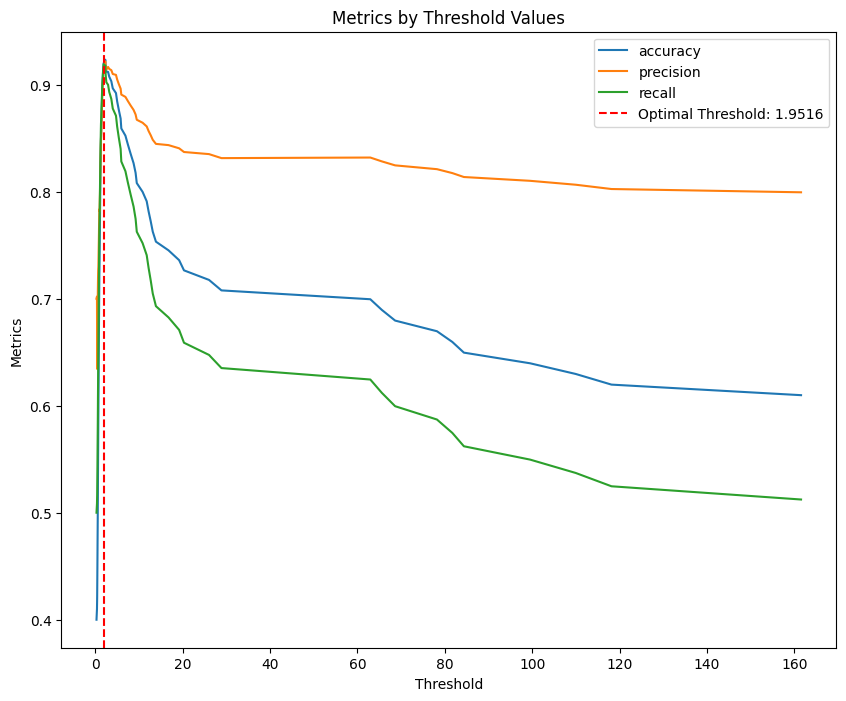

In [12]:

# Creating a DataFrame for reconstruction error and true labels
error_df = pd.DataFrame({
    'reconstruction_error': reconstruction_loss,
    'y_true': y_test
})

# Define a function to calculate metrics based on the threshold
def calculate_metrics(y_test, predictions, reconstruction_loss):
    auc = roc_auc_score(y_test, reconstruction_loss)
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    cm = confusion_matrix(y_test, predictions)
    tn, fp, fn, tp = cm.ravel()
    return auc, accuracy, precision, recall, f1, tn, fp, fn, tp

# Function to tune thresholds
def thresholdTuning(df, iterations):
    thresh_df = {
        'threshold': [],
        'accuracy': [],
        'precision': [],
        'recall': []
    }

    for i in range(iterations):
        thresh_value = df['reconstruction_error'].quantile(i / iterations)
        preds = df['reconstruction_error'] > thresh_value
        cr = classification_report(df['y_true'], preds, output_dict=True)
        acc = cr['accuracy']
        prec = cr['macro avg']['precision']
        rc = cr['macro avg']['recall']

        thresh_df['threshold'].append(thresh_value)
        thresh_df['accuracy'].append(acc)
        thresh_df['precision'].append(prec)
        thresh_df['recall'].append(rc)

        print(f"Threshold: {thresh_value:.4f}\tAccuracy: {acc:.3f}\t\tPrecision: {prec:.3f}\tRecall Score: {rc:.3f}")

    return pd.DataFrame(thresh_df)

# Optimizing thresholds
iterations = 100
thresh_df = thresholdTuning(error_df, iterations)

# Finding the optimal threshold based on recall
optimal_threshold_idx = thresh_df['recall'].idxmax()
optimal_threshold = thresh_df.iloc[optimal_threshold_idx]['threshold']

# Apply the optimal threshold to the data
predictions_optimal = (error_df['reconstruction_error'] > optimal_threshold).astype(np.int32)
auc_optimal, accuracy_optimal, precision_optimal, recall_optimal, f1_optimal, tn_optimal, fp_optimal, fn_optimal, tp_optimal = calculate_metrics(y_test, predictions_optimal, reconstruction_loss)

print(f'Optimal Threshold Optimization based on Recall:')
print(f'Optimal Threshold: {optimal_threshold:.4f}')
print(f'AUC: {auc_optimal:.4f}')
print(f'Accuracy: {accuracy_optimal:.4f}')
print(f'Precision: {precision_optimal:.4f}')
print(f'Recall: {recall_optimal:.4f}')
print(f'F1-score: {f1_optimal:.4f}')
print(f'TN: {tn_optimal}, FP: {fp_optimal}, FN: {fn_optimal}, TP: {tp_optimal}')
print()

# Plot confusion matrices for fixed and optimal thresholds in the same figure
fixed_threshold = 2.5
predictions_fixed = (error_df['reconstruction_error'] > fixed_threshold).astype(np.int32)
cm_fixed = confusion_matrix(y_test, predictions_fixed)
cm_optimal = confusion_matrix(y_test, predictions_optimal)

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Confusion matrix for threshold fixed at 2.5
axs[0].matshow(cm_fixed, cmap=plt.cm.Blues)
axs[0].set_title('Confusion Matrix (Threshold 2.5)')
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('True')
axs[0].set_xticks([0, 1])
axs[0].set_yticks([0, 1])
axs[0].set_xticklabels(['Legitimate', 'Fraudulent'])
axs[0].set_yticklabels(['Legitimate', 'Fraudulent'])
for (i, j), val in np.ndenumerate(cm_fixed):
    axs[0].text(j, i, f'{val}', ha='center', va='center', color='red')

# Confusion matrix for optimal threshold
axs[1].matshow(cm_optimal, cmap=plt.cm.Blues)
axs[1].set_title('Confusion Matrix (Optimal Threshold)')
axs[1].set_xlabel('Predicted')
axs[1].set_ylabel('True')
axs[1].set_xticks([0, 1])
axs[1].set_yticks([0, 1])
axs[1].set_xticklabels(['Legitimate', 'Fraudulent'])
axs[1].set_yticklabels(['Legitimate', 'Fraudulent'])
for (i, j), val in np.ndenumerate(cm_optimal):
    axs[1].text(j, i, f'{val}', ha='center', va='center', color='red')

plt.show()

# Plot metrics vs. threshold
plt.figure(figsize=(10, 8))
plt.plot(thresh_df['threshold'], thresh_df['accuracy'], label='accuracy')
plt.plot(thresh_df['threshold'], thresh_df['precision'], label='precision')
plt.plot(thresh_df['threshold'], thresh_df['recall'], label='recall')
plt.axvline(x=optimal_threshold, color='r', linestyle='dashed', label=f'Optimal Threshold: {optimal_threshold:.4f}')
plt.xlabel('Threshold')
plt.ylabel('Metrics')
plt.title('Metrics by Threshold Values')
plt.legend()
plt.show()
